In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
#import pca_tools
seed=31

In [2]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

### Read data and dpca

In [3]:
samples={
    "o0_c0": 0,
    "o1_c1": 1,
    "o1_c5": 2,
    "o5_c5": 3,
    "o5_c1": 4,
}

In [4]:
X_fr = from_python_hdf5('C:/Users/camil/Documents/int/dPCA-master/matlab/frlip.h5')[0]['pp']
N=X_fr.shape[1]
# trial-average data
X = np.mean(X_fr,0)
# center data
#X -= np.mean(X.reshape((N,-1)),1)[:,None,None]
print(X.shape)

(200, 5, 1050)


In [5]:
dpca = dPCA.dPCA(labels='st',join= {'st' : ['s','st']},regularizer=0,n_components=100,n_iter=5)#X_fr.shape[1]
dpca.protect = ['t']
#dpca.n_trials = 3
Z = dpca.fit_transform(X,X_fr)

In [7]:
variances = dpca.get_variances(X)

(10, 5, 1050)

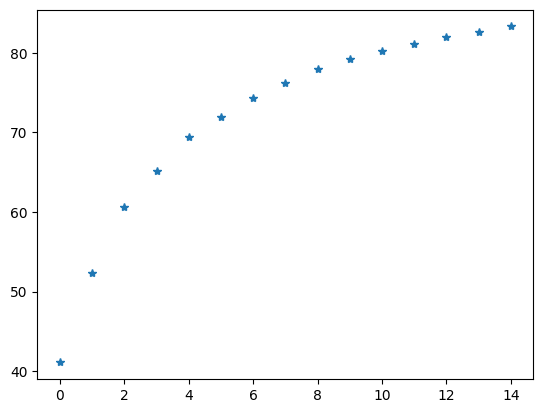

In [24]:
plt.plot(variances['cumulative_var'][:15],'*')
# trial-average data
X_full = np.mean(X_fr,0)
X = X_full.reshape((N,-1))
X_cen = X- np.mean(X,1)[:,None]

Z_full = X_cen.T@dpca.D_sorted
which_marg=variances['which_marg']
components =np.concatenate([np.where(which_marg==i)[0][:5] for i in ['st','s','t']])
Z= Z_full.T[components].reshape(np.concatenate((components.shape,X_full.shape[1:])))
Z.shape

In [25]:
variances.keys()

dict_keys(['cumulative_var', 'component_var', 'marg_var', 'total_marg_var', 'which_marg'])

In [26]:
n_comp=15
s_var = np.array(variances['marg_var']['s'][:n_comp])
t_var = np.array(variances['marg_var']['t'][:n_comp])
st_var = np.array(variances['marg_var']['st'][:n_comp])

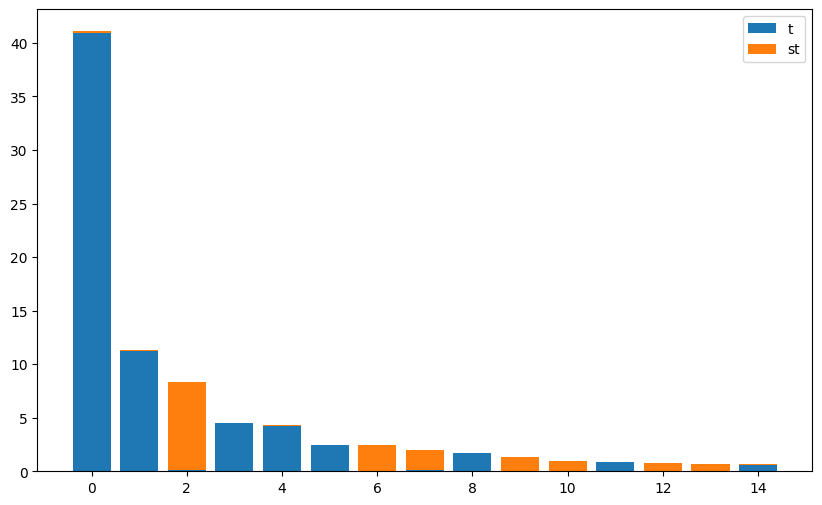

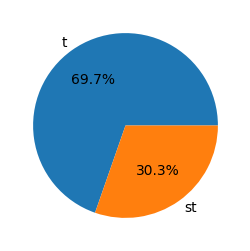

In [33]:
f,ax = plt.subplots(figsize=(10,6))
#ax.bar(range(n_comp),s_var, label='s')
ax.bar(range(n_comp),t_var, label='t')
ax.bar(range(n_comp),st_var, bottom= t_var, label='st')
ax.legend()
f,ax = plt.subplots(figsize=(3,3))
_=ax.pie([variances['total_marg_var']['t'],variances['total_marg_var']['st']],labels=['t','st'],autopct='%1.1f%%')

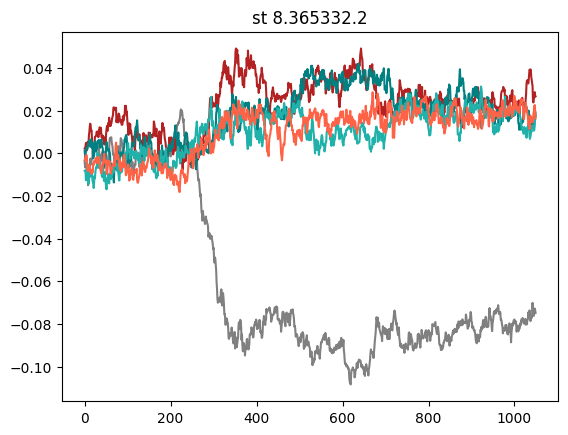

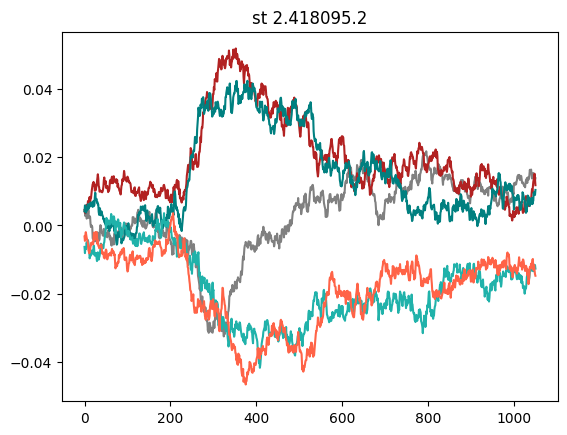

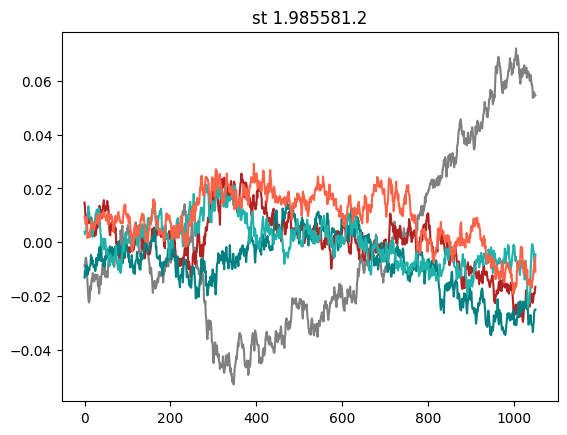

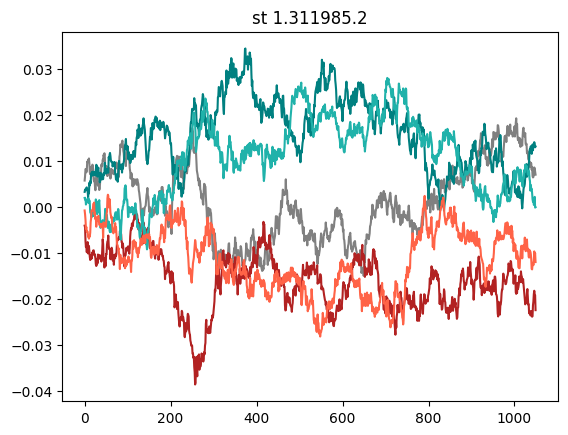

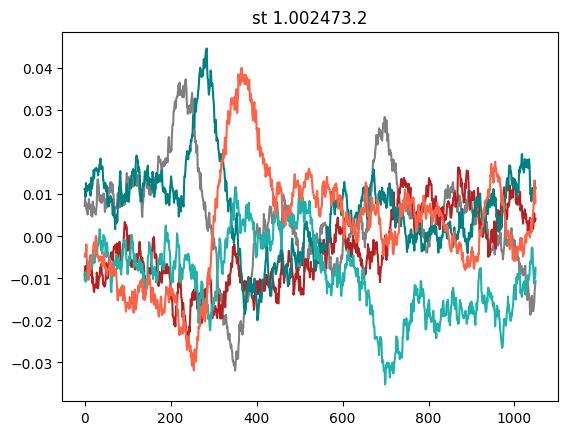

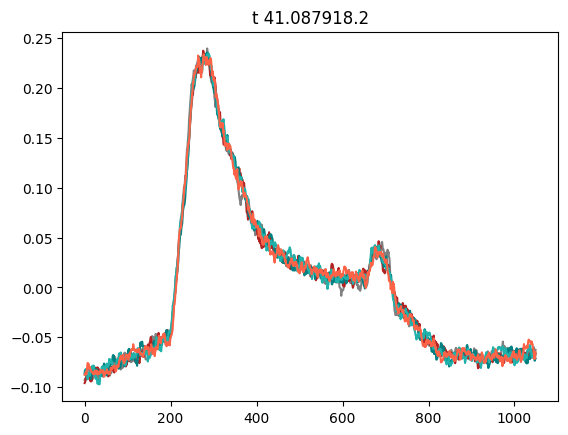

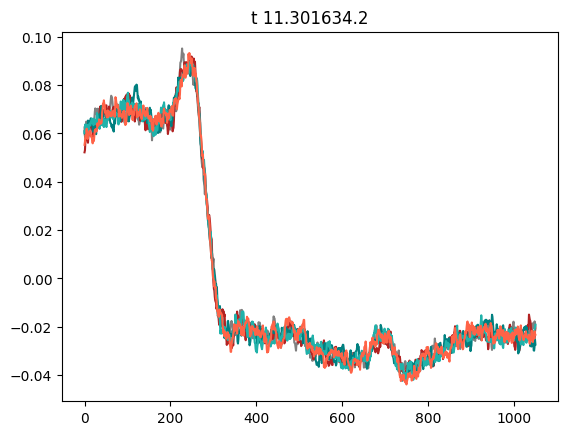

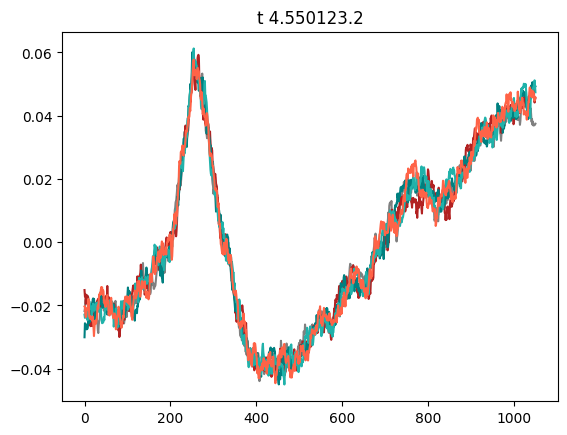

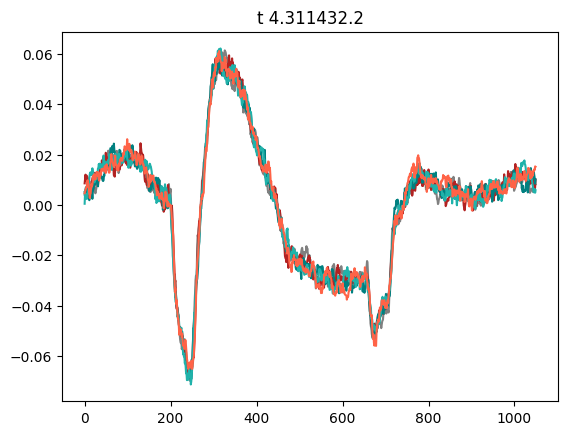

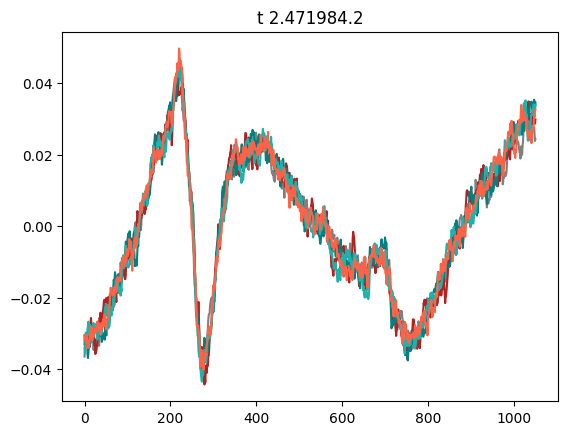

In [30]:
for i in range(Z.shape[0]):
    f,ax=plt.subplots()
    for s in samples.keys():
        ax.plot(Z[i][samples[s]],color=task_constants.PALETTE_B1[s])
    ax.set(title='%s %f.2'%(which_marg[components[i]],variances['component_var'][components][i]))